In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

/Users/chengchengfu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/chengchengfu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Set plot style
sns.set_style("whitegrid")


def load_and_clean_csv(filename, start_string):
    try:
        header_row = 0
        with open(filename, 'r') as f:
            for i, line in enumerate(f):
                if line.startswith(f'"{start_string}"'):
                    header_row = i
                    break
        
        if header_row == 0 and start_string == "Carrier Code":
             with open(filename, 'r') as f:
                for i, line in enumerate(f):
                    if line.startswith(f'{start_string}'): 
                        header_row = i
                        break

        df = pd.read_csv(filename, skiprows=header_row, quotechar='"')
        df.columns = df.columns.str.strip().str.replace(r'[\s\(\)]+', '_', regex=True)
        df = df.dropna(axis=1, how='all')
        
        print(f"Successfully loaded '{filename}'.")
        return df
    except Exception as e:
        print(f"An error occurred while loading '{filename}': {e}")
        return None

# Load both datasets
df_dep = load_and_clean_csv('data/departures.csv', 'Carrier Code')
df_arr = load_and_clean_csv('data/arrivals.csv', 'Carrier Code')

Successfully loaded 'data/departures.csv'.
Successfully loaded 'data/arrivals.csv'.


In [3]:
# Set display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# --- 1. Clean Departures (df_dep) ---
df_dep = df_dep.rename(columns={
    'Date_MM/DD/YYYY_': 'date',
    'Departure_delay_Minutes_': 'dep_delay',
    'Delay_Late_Aircraft_Arrival_Minutes_': 'dep_late_arr_delay' 
})
df_dep['Tail_Number'] = df_dep['Tail_Number'].str.strip()
df_dep['date'] = pd.to_datetime(df_dep['date'], format='%m/%d/%Y')
df_dep['time'] = pd.to_datetime(
    df_dep['date'].astype(str) + ' ' + df_dep['Actual_departure_time'],
    format='%Y-%m-%d %H:%M',
    errors='coerce'
)
df_dep['sched_time'] = pd.to_datetime(
    df_dep['date'].astype(str) + ' ' + df_dep['Scheduled_departure_time'],
    format='%Y-%m-%d %H:%M',
    errors='coerce'
)
mask = (df_dep['time'] < (df_dep['sched_time'] - pd.Timedelta(hours=12)))
df_dep.loc[mask, 'time'] += pd.Timedelta(days=1)
df_dep['type'] = 'departure'
df_dep_clean = df_dep.dropna(subset=['time', 'Tail_Number'])
df_dep_clean = df_dep_clean.add_prefix('dep_') 

# --- 2. Clean Arrivals (df_arr) ---
df_arr = df_arr.rename(columns={
    'Date_MM/DD/YYYY_': 'date',
    'Arrival_Delay_Minutes_': 'arr_delay',
    'Delay_Late_Aircraft_Arrival_Minutes_': 'arr_late_arr_delay'
})
df_arr['Tail_Number'] = df_arr['Tail_Number'].str.strip()
df_arr['date'] = pd.to_datetime(df_arr['date'], format='%m/%d/%Y')
df_arr['time'] = pd.to_datetime(
    df_arr['date'].astype(str) + ' ' + df_arr['Actual_Arrival_Time'],
    format='%Y-%m-%d %H:%M',
    errors='coerce'
)
df_arr['sched_time'] = pd.to_datetime(
    df_arr['date'].astype(str) + ' ' + df_arr['Scheduled_Arrival_Time'],
    format='%Y-%m-%d %H:%M',
    errors='coerce'
)
mask = (df_arr['time'] < (df_arr['sched_time'] - pd.Timedelta(hours=12)))
df_arr.loc[mask, 'time'] += pd.Timedelta(days=1)
df_arr['type'] = 'arrival'
df_arr_clean = df_arr.dropna(subset=['time', 'Tail_Number'])
df_arr_clean = df_arr_clean.add_prefix('arr_') 

# --- 3. Combine and Sort ---
df_dep_clean = df_dep_clean.rename(columns={'dep_Tail_Number': 'Tail_Number', 'dep_time': 'datetime'})
df_arr_clean = df_arr_clean.rename(columns={'arr_Tail_Number': 'Tail_Number', 'arr_time': 'datetime'})

df_events = pd.concat([df_arr_clean, df_dep_clean]).sort_values(by=['Tail_Number', 'datetime'])
print(f"Combined {len(df_events)} total arrival/departure events.")

# --- 4. Iterate and Find Pairs ---
turnaround_data = []

# Group by tail number
for tail_num, group in df_events.groupby('Tail_Number'):
    # Shift the data to get the 'previous' event
    group['prev_type'] = group['arr_type'].shift(1)
    group['prev_datetime'] = group['datetime'].shift(1)
    
    # --- ADD NEW FEATURES ---
    # Get the total delay AND the reasons for the previous flight
    group['prev_arr_origin'] = group['arr_Origin_Airport'].shift(1)
    group['prev_arr_delay'] = group['arr_arr_delay'].shift(1)
    group['prev_carrier_delay'] = group['arr_Delay_Carrier_Minutes_'].shift(1)
    group['prev_weather_delay'] = group['arr_Delay_Weather_Minutes_'].shift(1)
    group['prev_nas_delay'] = group['arr_Delay_National_Aviation_System_Minutes_'].shift(1)
    group['prev_security_delay'] = group['arr_Delay_Security_Minutes_'].shift(1)
    
    # Filter for rows that are 'departure' AND the previous event was 'arrival'
    departures_with_prev_arrival = group[
        (group['dep_type'] == 'departure') & (group['prev_type'] == 'arrival')
    ]
    
    turnaround_data.append(departures_with_prev_arrival)

# Combine all the valid pairs
df_model = pd.concat(turnaround_data)

# --- 5. Calculate Features ---
df_model['actual_turnaround_time_min'] = (
    df_model['datetime'] - df_model['prev_datetime']
).dt.total_seconds() / 60.0

# Rename new key features
df_model = df_model.rename(columns={
    'prev_arr_origin': 'inbound_origin_airport', 
    'prev_arr_delay': 'inbound_flight_arr_delay',
    'prev_carrier_delay': 'inbound_carrier_delay',
    'prev_weather_delay': 'inbound_weather_delay',
    'prev_nas_delay': 'inbound_nas_delay',
    'prev_security_delay': 'inbound_security_delay'
})

# --- 6. Clean for Modeling ---
df_model = df_model[
    (df_model['actual_turnaround_time_min'] > 10) & 
    (df_model['actual_turnaround_time_min'] < 480)
].copy()

# Fill NaNs in all new features (0 is a meaningful value)
inbound_delay_features = [
    'inbound_flight_arr_delay', 'inbound_carrier_delay', 'inbound_weather_delay',
    'inbound_nas_delay', 'inbound_security_delay', 'dep_dep_late_arr_delay'
]
for col in inbound_delay_features:
    df_model[col] = df_model[col].fillna(0)

df_model['inbound_origin_airport'] = df_model['inbound_origin_airport'].fillna('UNKNOWN')

# Fix column names (remove 'dep_' prefix)
df_model.columns = df_model.columns.str.replace(r'^dep_', '', regex=True)

print(f"Successfully merged {len(df_model)} flights with their inbound leg.")
print("New inbound delay features added.")


Combined 86803 total arrival/departure events.
Successfully merged 26695 flights with their inbound leg.
New inbound delay features added.


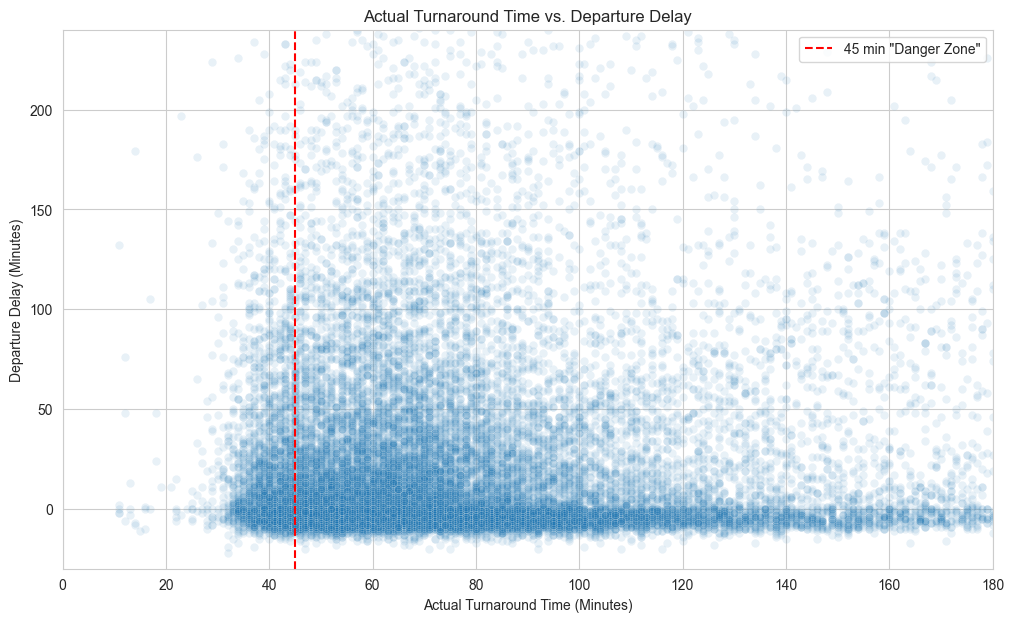

In [4]:
# Plot Turnaround Time vs. Next Departure Delay
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df_model,
    x='actual_turnaround_time_min',
    y='dep_delay',
    alpha=0.1
)
plt.title('Actual Turnaround Time vs. Departure Delay')
plt.xlabel('Actual Turnaround Time (Minutes)')
plt.ylabel('Departure Delay (Minutes)')
plt.xlim(0, 180) # Focus on 0-3 hour turns
plt.ylim(-30, 240) # Focus on reasonable delays
plt.axvline(x=45, color='red', linestyle='--', label='45 min "Danger Zone"')
plt.legend()
#plt.savefig('part2_eda_turnaround_vs_delay.png')
plt.show() 



In [5]:
# Define target
df_model['is_delayed'] = (df_model['dep_delay'] > 15).astype(int)

# --- Define features (X) and target (y) ---
df_model['sched_dep_hour'] = df_model['sched_time'].dt.hour
df_model['day_of_week_dep'] = df_model['sched_time'].dt.dayofweek
df_model['month_dep'] = df_model['sched_time'].dt.month

# --- ADD NEW FEATURES TO THE LIST ---
model_features = [
    'sched_dep_hour', 'day_of_week_dep', 'month_dep', 
    'Destination_Airport', 'Scheduled_elapsed_time_Minutes_',
    'inbound_flight_arr_delay',
    'inbound_carrier_delay', 
    'inbound_weather_delay', 
    'inbound_nas_delay',     
    'inbound_security_delay' 
]
X = df_model[model_features]
target_class = 'is_delayed'
y = df_model[target_class]

# --- ADD NEW FEATURES TO PREPROCESSOR ---
numerical_features = [
    'sched_dep_hour', 'Scheduled_elapsed_time_Minutes_', 'inbound_flight_arr_delay',
    'inbound_carrier_delay', 'inbound_weather_delay', 'inbound_nas_delay', 'inbound_security_delay'
]
categorical_features = ['day_of_week_dep', 'month_dep', 'Destination_Airport']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# --- Temporal Split ---
split_month = 11
train_indices = df_model['month_dep'] < split_month
test_indices = df_model['month_dep'] >= split_month

X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]

print(f"Classification: Training set size: {X_train.shape}")
print(f"Classification: Test set size: {X_test.shape}")

Classification: Training set size: (22757, 10)
Classification: Test set size: (3938, 10)


--- Training Classification Model ---

Random Forest Classifier - Classification Report:
              precision    recall  f1-score   support

     On-Time       0.82      0.88      0.85      2695
     Delayed       0.69      0.59      0.64      1243

    accuracy                           0.79      3938
   macro avg       0.76      0.74      0.75      3938
weighted avg       0.78      0.79      0.78      3938



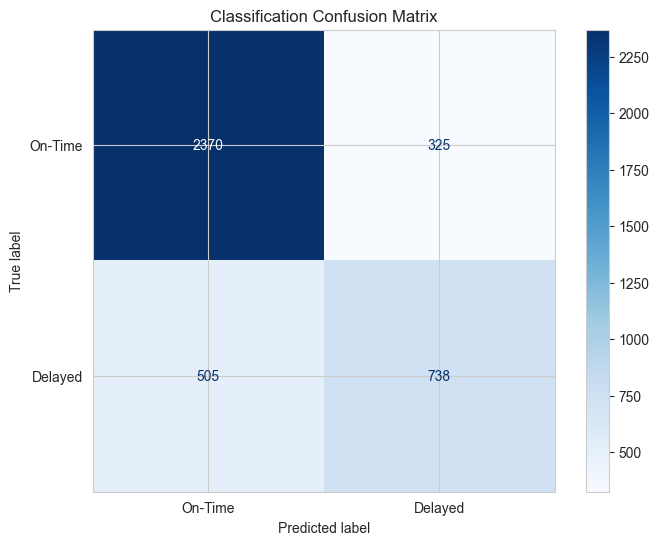

In [6]:
# Create the pipeline
clf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=20, class_weight='balanced'))
])


print("--- Training Classification Model ---")
clf_pipeline.fit(X_train, y_train)

# Predict on the full test set
y_pred_class = clf_pipeline.predict(X_test)

# Evaluate
print("\nRandom Forest Classifier - Classification Report:")
print(classification_report(y_test, y_pred_class, target_names=['On-Time', 'Delayed']))

# Plot Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(clf_pipeline, X_test, y_test, 
                                      display_labels=['On-Time', 'Delayed'], 
                                      cmap='Blues', ax=ax)
plt.title('Classification Confusion Matrix')
#plt.savefig('part3_clf_confusion_matrix.png')
plt.show() 

In [7]:
target_reg = 'dep_delay'
y_reg = df_model[target_reg]

# --- Setup for Model A (Schedule Only) ---
features_A = [
    'sched_dep_hour', 'day_of_week_dep', 'month_dep', 
    'Destination_Airport', 'Scheduled_elapsed_time_Minutes_'
]
X_A = df_model[features_A]
preprocessor_A = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['sched_dep_hour', 'Scheduled_elapsed_time_Minutes_']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['day_of_week_dep', 'month_dep', 'Destination_Airport'])
    ])

# --- Setup for Model B (With Inbound Delay Total) ---
features_B = [
    'sched_dep_hour', 'day_of_week_dep', 'month_dep', 
    'Destination_Airport', 'Scheduled_elapsed_time_Minutes_',
    'inbound_flight_arr_delay'
]
X_B = df_model[features_B]
preprocessor_B = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['sched_dep_hour', 'Scheduled_elapsed_time_Minutes_', 'inbound_flight_arr_delay']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['day_of_week_dep', 'month_dep', 'Destination_Airport'])
    ])

# --- Setup for Model C (Total + Reasons) ---
features_C = [
    'sched_dep_hour', 'day_of_week_dep', 'month_dep', 
    'Destination_Airport', 'Scheduled_elapsed_time_Minutes_',
    'inbound_flight_arr_delay', 
    'inbound_carrier_delay',    
    'inbound_weather_delay', 
    'inbound_nas_delay',     
    'inbound_security_delay' 
]
X_C = df_model[features_C]

# Define the numerical features for Preprocessor C
numerical_features_C = [
    'sched_dep_hour', 'Scheduled_elapsed_time_Minutes_', 'inbound_flight_arr_delay',
    'inbound_carrier_delay', 'inbound_weather_delay', 'inbound_nas_delay', 'inbound_security_delay'
]
categorical_features_C = ['day_of_week_dep', 'month_dep', 'Destination_Airport']

preprocessor_C = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features_C),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_C)
    ])


# --- Temporal Split for All ---
X_A_train, X_A_test = X_A[train_indices], X_A[test_indices]
X_B_train, X_B_test = X_B[train_indices], X_B[test_indices]
X_C_train, X_C_test = X_C[train_indices], X_C[test_indices]
y_reg_train, y_reg_test = y_reg[train_indices], y_reg[test_indices]

print(f"Regression: Training set size: {X_A_train.shape}")
print(f"Regression: Test set size: {X_A_test.shape}")

Regression: Training set size: (22757, 5)
Regression: Test set size: (3938, 5)


In [8]:
# Helper function for metrics
def print_regression_metrics(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} Metrics ---")
    print(f"  R-squared (R²): {r2:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.2f} minutes")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.2f} minutes")
    return {"Model": model_name, "R²": r2, "MAE": mae, "RMSE": rmse}

all_metrics = []

# --- Train Model A (Schedule Only) ---
xgb_pipeline_A = Pipeline(steps=[
    ('preprocessor', preprocessor_A),
    ('regressor', XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10))
])
print("\n--- Training Model A (Schedule Only) ---")
xgb_pipeline_A.fit(X_A_train, y_reg_train)
y_pred_A = xgb_pipeline_A.predict(X_A_test)
metrics_A = print_regression_metrics(y_reg_test, y_pred_A, "Model A: Schedule Only")
all_metrics.append(metrics_A)

# --- Train Model B (With Inbound Delay Total) ---
xgb_pipeline_B = Pipeline(steps=[
    ('preprocessor', preprocessor_B),
    ('regressor', XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10))
])
print("\n--- Training Model B (With Inbound Delay Total) ---")
xgb_pipeline_B.fit(X_B_train, y_reg_train)
y_pred_B = xgb_pipeline_B.predict(X_B_test)
metrics_B = print_regression_metrics(y_reg_test, y_pred_B, "Model B: With Inbound Total")
all_metrics.append(metrics_B)

# --- Train Model C (Total + Reasons) ---
xgb_pipeline_C = Pipeline(steps=[
    ('preprocessor', preprocessor_C),
    ('regressor', XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10))
])
print("\n--- Training Model C (Total + Reasons) ---")
xgb_pipeline_C.fit(X_C_train, y_reg_train)
y_pred_C = xgb_pipeline_C.predict(X_C_test)
metrics_C = print_regression_metrics(y_reg_test, y_pred_C, "Model C: Total + Reasons")
all_metrics.append(metrics_C)

# --- Compare Metrics ---
metrics_df = pd.DataFrame(all_metrics)
print("\n--- Regression Model Comparison ---")

print(metrics_df)


--- Training Model A (Schedule Only) ---
--- Model A: Schedule Only Metrics ---
  R-squared (R²): -0.0857
  Mean Absolute Error (MAE): 30.19 minutes
  Root Mean Squared Error (RMSE): 47.53 minutes

--- Training Model B (With Inbound Delay Total) ---
--- Model B: With Inbound Total Metrics ---
  R-squared (R²): 0.1825
  Mean Absolute Error (MAE): 24.47 minutes
  Root Mean Squared Error (RMSE): 41.25 minutes

--- Training Model C (Total + Reasons) ---
--- Model C: Total + Reasons Metrics ---
  R-squared (R²): 0.2246
  Mean Absolute Error (MAE): 23.91 minutes
  Root Mean Squared Error (RMSE): 40.17 minutes

--- Regression Model Comparison ---
                         Model        R²        MAE       RMSE
0       Model A: Schedule Only -0.085661  30.192800  47.533903
1  Model B: With Inbound Total  0.182474  24.465809  41.248405
2     Model C: Total + Reasons  0.224604  23.913124  40.171509


In [9]:
# --- 1. Define the Pipeline ---
xgb_pipeline_C = Pipeline(steps=[
    ('preprocessor', preprocessor_C),
    ('regressor', XGBRegressor(random_state=42, n_jobs=-1))
])

# --- 2. Define the Search Space ---
param_dist = {
    'regressor__n_estimators': randint(100, 500), 
    'regressor__max_depth': randint(5, 15),       
    'regressor__learning_rate': uniform(0.01, 0.3),
    'regressor__subsample': uniform(0.7, 0.3),      
    'regressor__colsample_bytree': uniform(0.7, 0.3) 
}

# --- 3. Create the Search Object ---
random_search = RandomizedSearchCV(
    estimator=xgb_pipeline_C,
    param_distributions=param_dist,
    n_iter=100,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("--- Starting Hyperparameter Tuning for Model C ---")
# Train on the full training set
random_search.fit(X_C_train, y_reg_train)

print("\n--- Tuning Complete ---")
print(f"Best parameters found: {random_search.best_params_}")

--- Starting Hyperparameter Tuning for Model C ---
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/chengchengfu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/chengchengfu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/chengchengfu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/chengchengfu/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5'


--- Tuning Complete ---
Best parameters found: {'regressor__colsample_bytree': 0.7348217921520748, 'regressor__learning_rate': 0.023800792606525824, 'regressor__max_depth': 5, 'regressor__n_estimators': 193, 'regressor__subsample': 0.9566381752033022}


In [10]:
# --- 1. Get the best model found by the search ---
best_tuned_model = random_search.best_estimator_

# --- 2. Predict on the test set ---
y_pred_C_tuned = best_tuned_model.predict(X_C_test)

# --- 3. Report metrics ---
print("\n--- Tuned Model C - Final Test Set Evaluation ---")
metrics_C_tuned = print_regression_metrics(y_reg_test, y_pred_C_tuned, "Model C: Tuned")

# --- 4. Add to our comparison DataFrame ---
all_metrics.append(metrics_C_tuned)
metrics_df = pd.DataFrame(all_metrics)

print("\n--- Final Regression Model Comparison ---")
print(metrics_df)


--- Tuned Model C - Final Test Set Evaluation ---
--- Model C: Tuned Metrics ---
  R-squared (R²): 0.3223
  Mean Absolute Error (MAE): 22.71 minutes
  Root Mean Squared Error (RMSE): 37.55 minutes

--- Final Regression Model Comparison ---
                         Model        R²        MAE       RMSE
0       Model A: Schedule Only -0.085661  30.192800  47.533903
1  Model B: With Inbound Total  0.182474  24.465809  41.248405
2     Model C: Total + Reasons  0.224604  23.913124  40.171509
3               Model C: Tuned  0.322348  22.707569  37.554312


In [12]:
best_tuned_model = random_search.best_estimator_

# Predict on the ORIGINAL test set
y_pred_baseline = best_tuned_model.predict(X_C_test)

baseline_total_delay = np.sum(y_pred_baseline[y_pred_baseline > 0])

print(f"--- Baseline Scenario ---")
print(f"Total Predicted Departure Delay (Nov-Dec): {baseline_total_delay:,.0f} minutes")

--- Baseline Scenario ---
Total Predicted Departure Delay (Nov-Dec): 92,115 minutes


In [13]:
X_test_hypo = X_C_test.copy()

# Define inbound delay features and the threshold
inbound_delay_cols = [
    'inbound_flight_arr_delay',
    'inbound_carrier_delay',
    'inbound_weather_delay',
    'inbound_nas_delay',
    'inbound_security_delay'
]
threshold = 20.0

# Find all rows where the total inbound delay was over 20 minutes
rows_to_fix = X_test_hypo['inbound_flight_arr_delay'] > threshold

# --- Apply our Fix ---
X_test_hypo.loc[rows_to_fix, 'inbound_flight_arr_delay'] = threshold

X_test_hypo.loc[rows_to_fix, 'inbound_carrier_delay'] = 0
X_test_hypo.loc[rows_to_fix, 'inbound_weather_delay'] = 0
X_test_hypo.loc[rows_to_fix, 'inbound_nas_delay'] = 0
X_test_hypo.loc[rows_to_fix, 'inbound_security_delay'] = 0

num_flights_fixed = rows_to_fix.sum()
print(f"--- Hypothetical Scenario Created ---")
print(f"Simulated fixing {num_flights_fixed} at-risk inbound flights.")

--- Hypothetical Scenario Created ---
Simulated fixing 836 at-risk inbound flights.


In [14]:
# Predict on the new "optimized" data
y_pred_hypo = best_tuned_model.predict(X_test_hypo)

# Sum up the positive delays from our new scenario
hypo_total_delay = np.sum(y_pred_hypo[y_pred_hypo > 0])

# --- Calculate the Savings ---
total_savings = baseline_total_delay - hypo_total_delay
percent_reduction = (total_savings / baseline_total_delay) * 100

print("\n--- Optimization Simulation Results ---")
print(f"Baseline Total Delay:   {baseline_total_delay:,.0f} minutes")
print(f"Optimized Total Delay:  {hypo_total_delay:,.0f} minutes")
print("------------------------------------------")
print(f"Total Minutes Saved:    {total_savings:,.0f} minutes")
print(f"Percent Reduction:    {percent_reduction:.2f}%")


--- Optimization Simulation Results ---
Baseline Total Delay:   92,115 minutes
Optimized Total Delay:  63,895 minutes
------------------------------------------
Total Minutes Saved:    28,220 minutes
Percent Reduction:    30.64%


In [15]:
df_arr_analysis = df_arr_clean.copy()
df_arr_analysis.columns = df_arr_analysis.columns.str.replace(r'^arr_', '', regex=True)

# Remove whitespace
df_arr_analysis['Origin_Airport'] = df_arr_analysis['Origin_Airport'].str.strip()

# Group by origin airport and get the mean delay and flight count
origin_stats = df_arr_analysis.groupby('Origin_Airport')['arr_delay'].agg(['mean', 'count'])
origin_stats = origin_stats.rename(columns={'mean': 'avg_delay_min', 'count': 'flight_count'})

# Filter for major airports
major_airports = origin_stats[origin_stats['flight_count'] > 200].copy()

# Get the Top 20 highest delay routes
top_20_risky_airports = major_airports.sort_values(by='avg_delay_min', ascending=False).head(20)
risky_airports_list = top_20_risky_airports.index.tolist()

print("--- Top 20 Highest Delay Inbound Routes (by Avg. Arrival Delay) ---")
print(top_20_risky_airports)
print(f"\nRisky list: {risky_airports_list}")

--- Top 20 Highest Delay Inbound Routes (by Avg. Arrival Delay) ---
                avg_delay_min  flight_count
Origin_Airport                             
SEA                 55.626106           452
ONT                 54.876712           365
PDX                 54.142857           217
IAH                 47.202469           405
LAS                 45.933382          1366
SLC                 45.727858           621
BUR                 36.831956           363
SAT                 36.413223           363
ABQ                 36.350230           217
FLL                 34.634505          2446
MIA                 34.179039          1145
SMF                 33.928571           364
MCO                 33.909180          3050
MVY                 31.319149           235
DEN                 30.871845           515
ACK                 30.648387           310
ATL                 30.426905          1286
PHX                 30.251485           505
RDU                 26.783497          1224
SJU     

In [16]:
test_set_full_data = df_model.loc[test_indices]

# Create our new hypothetical feature set
X_test_surgical = X_C_test.copy()
threshold = 20.0

# --- Find the specific rows to fix ---
# 1. Find rows where the inbound origin was a risky airport
is_risky_route = test_set_full_data['inbound_origin_airport'].str.strip().isin(risky_airports_list)

# 2. Find rows where the inbound delay was over our threshold
is_delayed_inbound = test_set_full_data['inbound_flight_arr_delay'] > threshold

# 3. Combine them: We only fix rows that are BOTH risky AND delayed
rows_to_fix_mask = is_risky_route & is_delayed_inbound

# --- Apply the "Surgical Fix" ---
# 1. Cap the total delay
X_test_surgical.loc[rows_to_fix_mask, 'inbound_flight_arr_delay'] = threshold

# 2. Zero out the *reason* columns for the fixed rows
inbound_reason_cols = [
    'inbound_carrier_delay', 'inbound_weather_delay', 
    'inbound_nas_delay', 'inbound_security_delay'
]
X_test_surgical.loc[rows_to_fix_mask, inbound_reason_cols] = 0

num_flights_fixed = rows_to_fix_mask.sum()
print(f"--- 'Surgical Fix' Scenario Created ---")
print(f"Simulated fixing {num_flights_fixed} at-risk flights from Top 20 risky routes.")

--- 'Surgical Fix' Scenario Created ---
Simulated fixing 318 at-risk flights from Top 20 risky routes.


In [17]:
best_tuned_model = random_search.best_estimator_

# --- 1. Baseline ---
y_pred_baseline = best_tuned_model.predict(X_C_test)
baseline_total_delay = np.sum(y_pred_baseline[y_pred_baseline > 0])

# --- 2. Surgical Fix ---
y_pred_surgical = best_tuned_model.predict(X_test_surgical)
surgical_total_delay = np.sum(y_pred_surgical[y_pred_surgical > 0])

# --- 3. Cap All ---
X_test_cap_all = X_C_test.copy()
rows_to_fix_all = X_test_cap_all['inbound_flight_arr_delay'] > threshold
X_test_cap_all.loc[rows_to_fix_all, 'inbound_flight_arr_delay'] = threshold
X_test_cap_all.loc[rows_to_fix_all, inbound_reason_cols] = 0

y_pred_cap_all = best_tuned_model.predict(X_test_cap_all)
cap_all_total_delay = np.sum(y_pred_cap_all[y_pred_cap_all > 0])

# --- 4. Compare ---
surgical_savings = baseline_total_delay - surgical_total_delay
cap_all_savings = baseline_total_delay - cap_all_total_delay
percent_of_max = (surgical_savings / cap_all_savings) * 100

print("\n--- Optimization Simulation Results ---")
print(f"Baseline Total Delay:        {baseline_total_delay:,.0f} minutes")
print(f"'Cap All' Total Delay:        {cap_all_total_delay:,.0f} minutes")
print(f"'Surgical Fix' Total Delay:  {surgical_total_delay:,.0f} minutes")
print("------------------------------------------")
print(f"Max Possible Savings ('Cap All'):   {cap_all_savings:,.0f} minutes")
print(f"Targeted Savings ('Surgical'):  {surgical_savings:,.0f} minutes")
print("------------------------------------------")
print(f"By fixing the Top 20 highest delay inbound routes, we captured {percent_of_max:.1f}% of the total possible savings.")


--- Optimization Simulation Results ---
Baseline Total Delay:        92,115 minutes
'Cap All' Total Delay:        63,895 minutes
'Surgical Fix' Total Delay:  81,297 minutes
------------------------------------------
Max Possible Savings ('Cap All'):   28,220 minutes
Targeted Savings ('Surgical'):  10,818 minutes
------------------------------------------
By fixing the Top 20 highest delay inbound routes, we captured 38.3% of the total possible savings.
